# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Tuning
5. Modelling
6. Evaluation


# Set-Up

## Import Library

In [2]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data preprocessing
from sklearn.preprocessing import (
    LabelEncoder, 
    OrdinalEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
)

# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, classification_report,confusion_matrix, accuracy_score

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [3]:
data_btc = pd.read_csv("/home/user/forecast-tse-arima/dataset/BTC-USD.csv")
data_eth = pd.read_csv("/home/user/forecast-tse-arima/dataset/ETH-USD.csv")
data_bnb = pd.read_csv("/home/user/forecast-tse-arima/dataset/BNB-USD.csv")
data_sol = pd.read_csv("/home/user/forecast-tse-arima/dataset/SOL-USD.csv")
data_xrp = pd.read_csv("/home/user/forecast-tse-arima/dataset/XRP-USD.csv")

# EDA

In [4]:
data_btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...,...
1090,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
1091,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
1092,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
1093,2023-12-30,42091.753906,42584.125000,41556.226563,42156.902344,42156.902344,16013925945


In [5]:
data_btc.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
print(f"Data memiliki {data_btc.shape[0]} baris dan {data_btc.shape[1]} kolom")
drop = data_btc.drop_duplicates()
print(f"Data setelah dihapus duplikat memiliki: {drop.shape[0]} baris dan {drop.shape[1]} kolom")

Data memiliki 1095 baris dan 7 kolom
Data setelah dihapus duplikat memiliki: 1095 baris dan 7 kolom


In [7]:
data_btc.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1095.0,3.482320e+04,1.256097e+04,1.578230e+04,2.470548e+04,3.213887e+04,4.353272e+04,6.754973e+04
High,1095.0,3.561568e+04,1.292156e+04,1.625305e+04,2.521547e+04,3.332710e+04,4.418802e+04,6.878962e+04
Low,1095.0,3.395326e+04,1.213239e+04,1.559905e+04,2.427638e+04,3.103027e+04,4.256395e+04,6.638206e+04
Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Adj Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Volume,1095.0,3.180665e+10,2.053404e+10,5.331173e+09,1.863833e+10,2.783388e+10,3.851887e+10,3.509679e+11


In [8]:
data_btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1095 non-null   object 
 1   Open       1095 non-null   float64
 2   High       1095 non-null   float64
 3   Low        1095 non-null   float64
 4   Close      1095 non-null   float64
 5   Adj Close  1095 non-null   float64
 6   Volume     1095 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


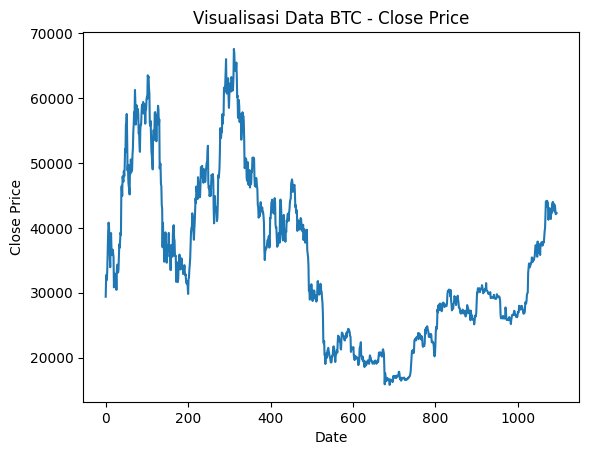

In [9]:
plt.plot(data_btc['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Visualisasi Data BTC - Close Price')
plt.show()


# Data Preprocessing

In [10]:
data_btc['Date'] = pd.to_datetime(data_btc['Date'], format='%Y-%m-%d')


In [11]:
data_btc['year'] = data_btc['Date'].dt.year
data_btc['month'] = data_btc['Date'].dt.month
data_btc['day'] = data_btc['Date'].dt.day

In [20]:
# data btc close
df_btc_close_year = data_btc[['year', 'Close']]

In [25]:
#resamply by years
df_year = data_btc.resample('Y').mean()

/tmp/ipykernel_16189/586279662.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_year = data_btc.resample('Y').mean()


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

# Tuning

# Modelling

## Triple Exponential Smoothing

## ARIMA

# Evaluation